# Prédiction de Salaires - Régression Linéaire Multiple

## Objectif
Ce notebook présente une analyse complète de régression linéaire multiple pour prédire les salaires des employés.

## Plan d'analyse
1. **Exploration des données**
2. **Préparation des données**
3. **Modélisation**
   - Baseline avec DummyRegressor
   - Régression linéaire simple
4. **Réugularisation avec GridSearchCV**
   - Ridge Regression (L2)
   - Lasso Regression (L1)
6. **Résumé et Comparaison Finale**

In [1]:
# Import des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Chargement et Exploration des Données

In [2]:
# Chargement des données
df = pd.read_csv("data/employee_salaries.csv")
df.head(5)

# TO DO : Charger le dataset employee_salaries.csv dans un DataFrame pandas et afficher les 5 premières lignes ainsi que la shape du dataset

,age,experience,education_years,heures_semaine,nb_projets,evaluation_performance,anciennete_entreprise,niveau_education,departement,poste,ville,secteur,taille_entreprise,salaire_annuel
0,38,5,0,39,3.0,2.9,2,Bac,Marketing,Senior,Paris,Services,Grande Entreprise,95600.0
1,29,0,1,35,1.0,4.6,0,Bac,Finance,Junior,Paris,Services,ETI,41500.0
2,25,1,0,37,0.0,4.4,0,Bac,R&D,Junior,Autres,Santé,Grande Entreprise,44300.0
3,25,1,4,40,3.0,7.4,0,Master,Ventes,Junior,Toulouse,Services,ETI,57100.0
4,37,5,1,41,7.0,5.0,0,Bac,IT,Senior,Paris,Tech,ETI,128000.0


In [3]:
df.shape


(10000, 14)

In [4]:
# Informations sur le dataset et statistiques descriptives
df.info()
df.describe()
df.isnull().sum()
# TO DO : Afficher les informations statistiques sur le dataset ainsi que le nombre de valeurs manquantes par colonne

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     10000 non-null  int64  
 1   experience              10000 non-null  int64  
 2   education_years         10000 non-null  int64  
 3   heures_semaine          10000 non-null  int64  
 4   nb_projets              9900 non-null   float64
 5   evaluation_performance  9800 non-null   float64
 6   anciennete_entreprise   10000 non-null  int64  
 7   niveau_education        10000 non-null  object 
 8   departement             10000 non-null  object 
 9   poste                   10000 non-null  object 
 10  ville                   10000 non-null  object 
 11  secteur                 10000 non-null  object 
 12  taille_entreprise       10000 non-null  object 
 13  salaire_annuel          10000 non-null  float64
dtypes: float64(3), int64(5), object(6)
memo

age                         0
experience                  0
education_years             0
heures_semaine              0
nb_projets                100
evaluation_performance    200
anciennete_entreprise       0
niveau_education            0
departement                 0
poste                       0
ville                       0
secteur                     0
taille_entreprise           0
salaire_annuel              0
dtype: int64

In [5]:
# Séparation des variables numériques et catégorielles
# Séparation des variables numériques et catégorielles
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Variables numériques :", numerical_features)
print("Variables catégorielles :", categorical_features)

# TO DO : créer deux listes qui séparent les variables numériques et catégorielles

Variables numériques : ['age', 'experience', 'education_years', 'heures_semaine', 'nb_projets', 'evaluation_performance', 'anciennete_entreprise', 'salaire_annuel']
Variables catégorielles : ['niveau_education', 'departement', 'poste', 'ville', 'secteur', 'taille_entreprise']


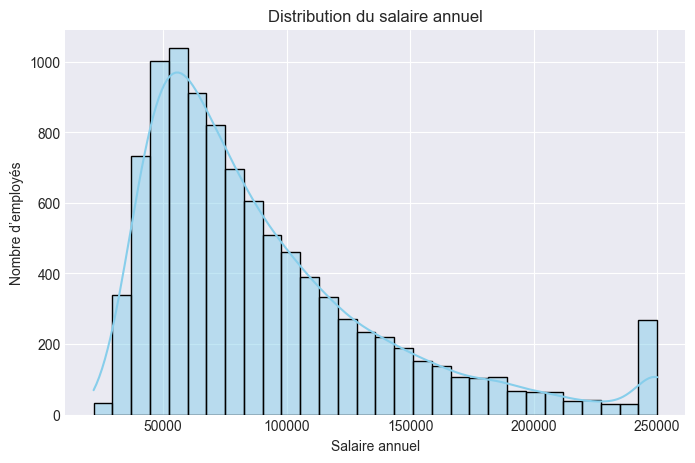

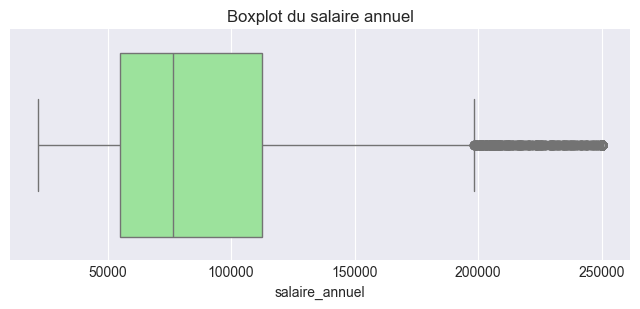

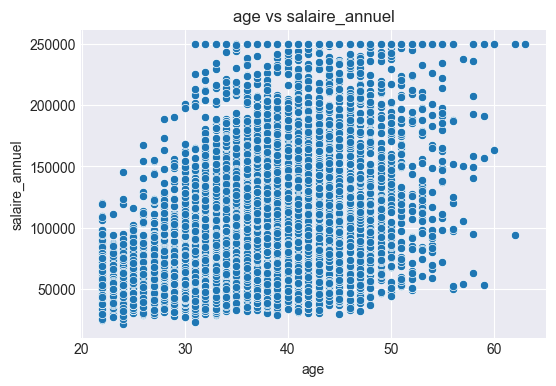

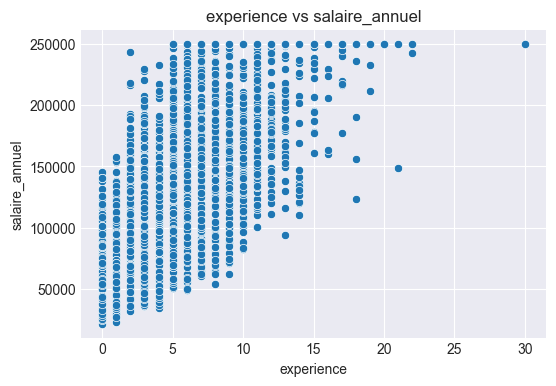

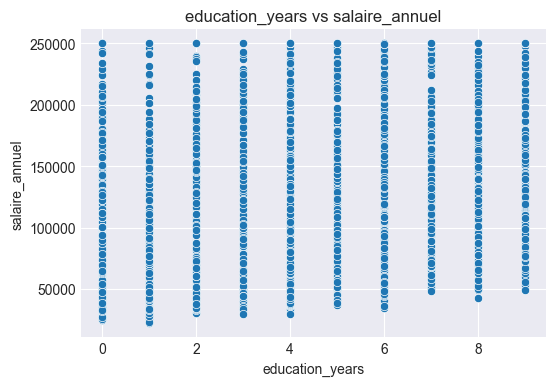

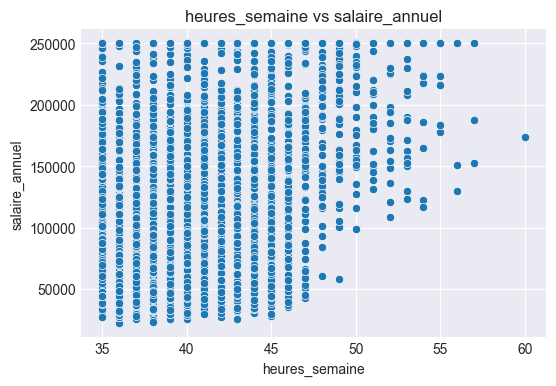

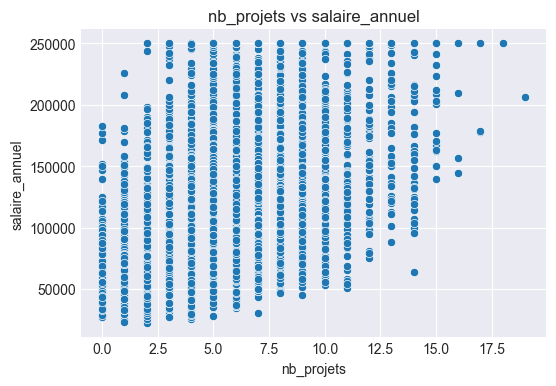

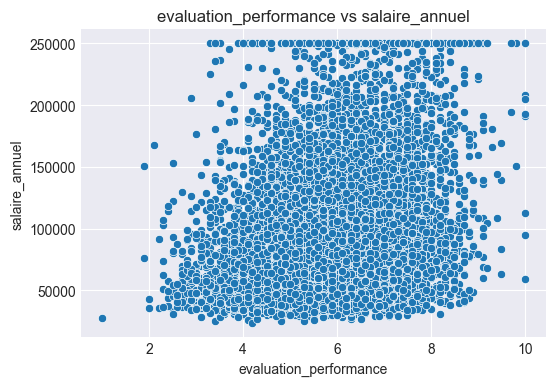

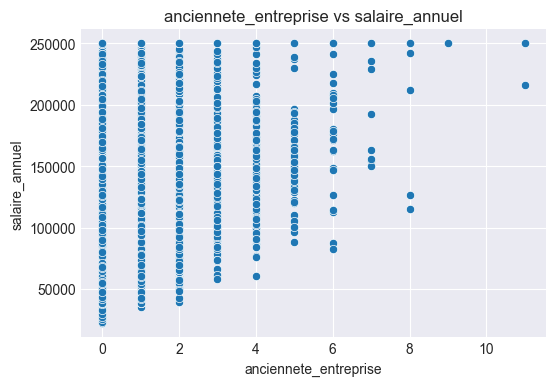

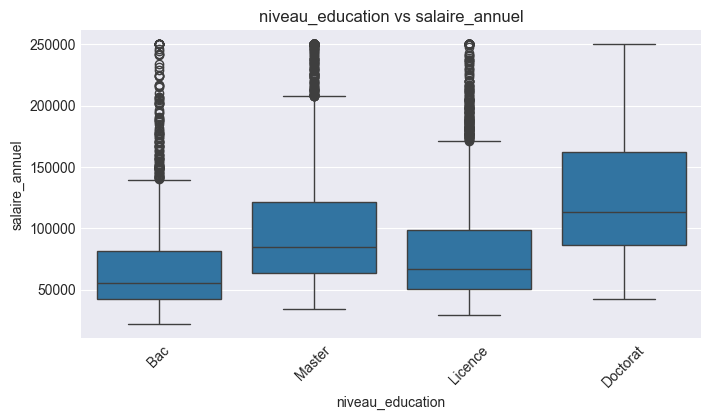

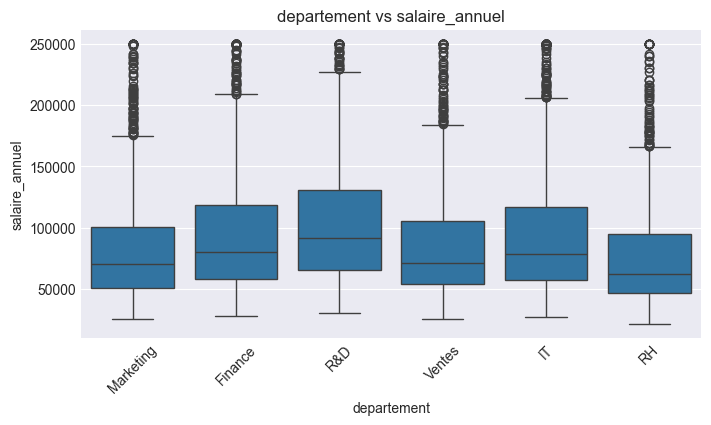

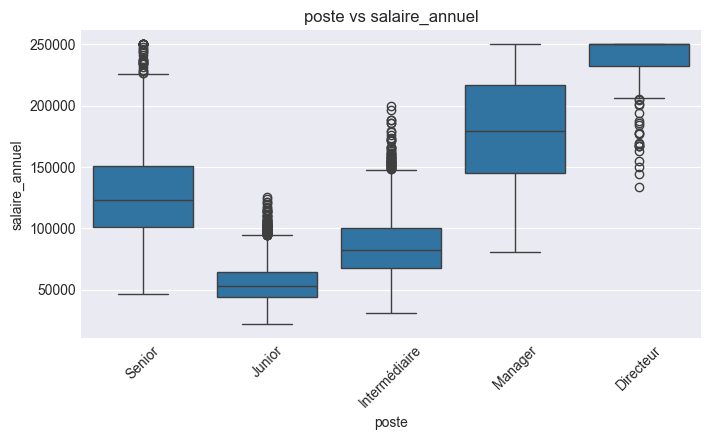

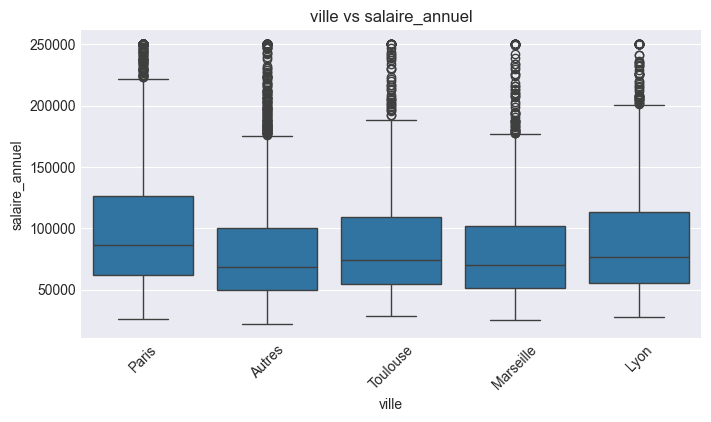

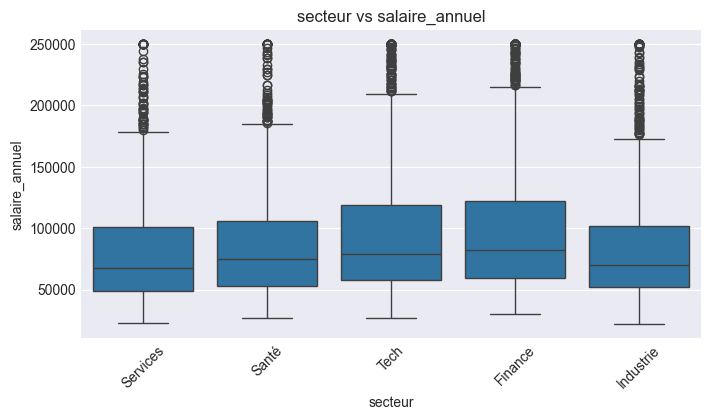

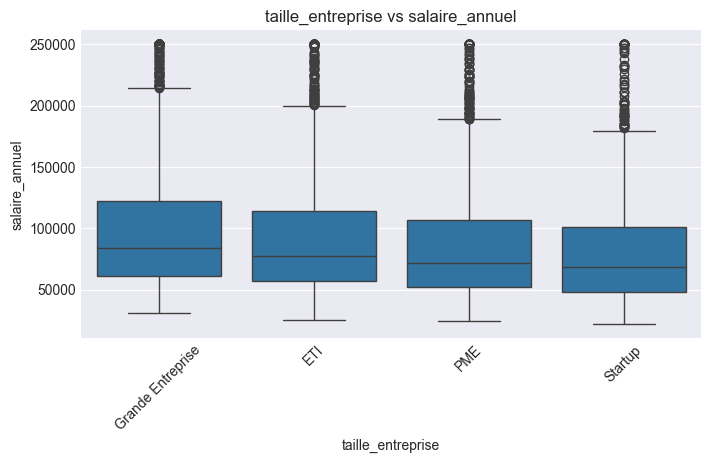

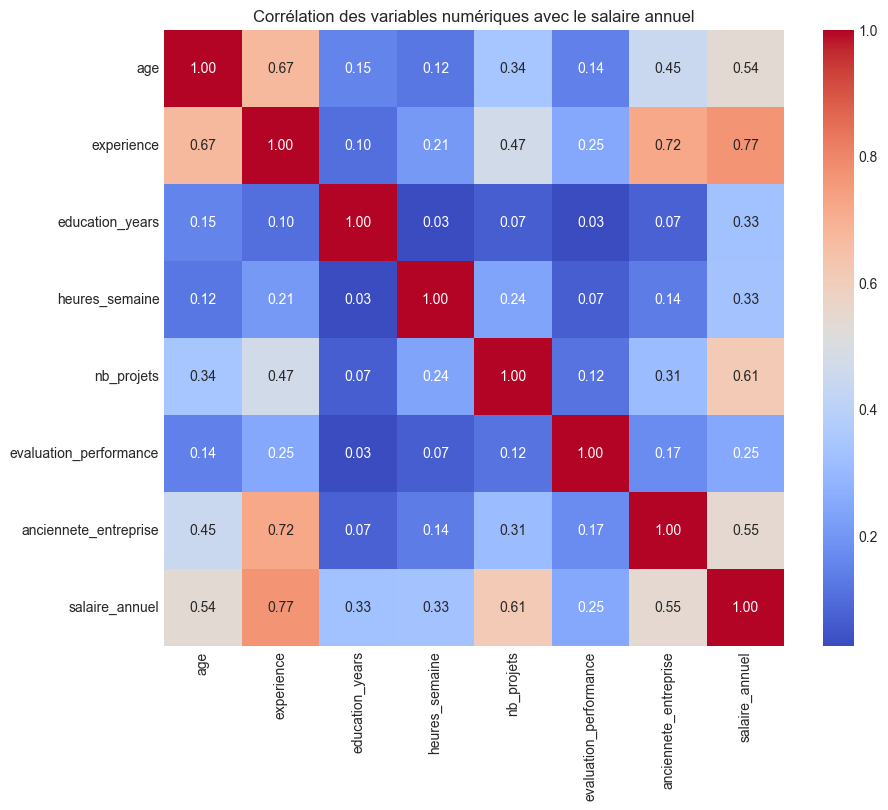

In [6]:
# Analyse des données
target = 'salaire_annuel'
if target in numerical_features:
    numerical_features.remove(target)

plt.figure(figsize=(8,5))
sns.histplot(df[target], kde=True, bins=30, color='skyblue')
plt.title('Distribution du salaire annuel')
plt.xlabel('Salaire annuel')
plt.ylabel('Nombre d’employés')
plt.show()

plt.figure(figsize=(8,3))
sns.boxplot(x=df[target], color='lightgreen')
plt.title('Boxplot du salaire annuel')
plt.show()

for col in numerical_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x=col, y=target)
    plt.title(f'{col} vs {target}')
    plt.show()

for col in categorical_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=col, y=target, data=df)
    plt.title(f'{col} vs {target}')
    plt.xticks(rotation=45)
    plt.show()

plt.figure(figsize=(10,8))
corr_matrix = df[numerical_features + [target]].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Corrélation des variables numériques avec le salaire annuel')
plt.show()
# TO DO : Analyser les données avec des visualisations appropriées (histogrammes, boxplots, heatmap de corrélation, etc.) 
# pour comprendre la distribution des variables et leurs relations avec la variable cible 'salaire'

## 2. Préparation des Données

### 2.1 Séparation des features et de la cible

In [7]:
# Séparation des features (X) et de la cible (y)
# Séparer les données en dataset de features (X) et dataset de cible (y)
target = 'salaire_annuel'

X = df.drop(columns=[target])  
y = df[target]                 

print("Dimensions de X :", X.shape)
print("Dimensions de y :", y.shape)

Dimensions de X : (10000, 13)
Dimensions de y : (10000,)


In [ ]:
# Division en ensemble d'entraînement et de test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Spliter les données en ensembles d'entraînement et de test (80/20) et utiliser l'arribut random_state=42 

### 2.2 Preprocessing Pipeline

Nous allons créer un pipeline de preprocessing qui:
1. Impute les valeurs manquantes pour les variables numériques
2. Applique le scaling sur les variables numériques
3. Applique le one-hot encoding sur les variables catégorielles

In [18]:
# TO DO : implémenter des stratégie de prétraitement des données numériques et catégorielles en utilisant ColumnTransformer et Pipeline

## 3. Modélisation

### 3.1 Modèle de Base - DummyRegressor

In [11]:
# TO DO : Entrainer un modèle DummyRegressor, qui servira de baseline, et évaluer ses performances sur l'ensemble de test

### 3.2 Régression Linéaire Simple

In [ ]:
# TO DO : Entrainer un modèle de régression linaire

In [12]:
# TO DO : afficher les valeurs prédites par le modèle linéaire vs les valeurs réelles du dataset de test

In [16]:
# TO DO : afficher les valeurs des coefficients du modèle linéaire

## 4. Régularisation avec GridSearchCV

In [ ]:
# TO DO : Entrainer un modèle Ridge en testant les hyerparamètres suivants : 
#    - 'alpha': np.logspace(-3, 2, 20),
#    - 'selection': ['cyclic', 'random']
# Afficher les résultats de la cross validation et les performances sur l'ensemble de test 

In [17]:
# TO DO : Entrainer un modèle Ridge en testant les hyerparamètres suivants : 
#    - 'alpha': np.logspace(-3, 3, 20),
#    - 'solver': ['auto', 'svd', 'cholesky', 'lsqr']
# Afficher les résultats de la cross validation et les performances sur l'ensemble de test

## 5. Résumé et Comparaison Finale

In [19]:
# TO : Afficher pour chaque modèle (dummy, linéaire, ridge, lasso) les performances sur l'ensemble d'entrainement et de test et conclure
# sur le choix du modèle et sa capacité de généralisation